<a href="https://colab.research.google.com/github/argenis-gomez/Imagenes-BN-a-Color/blob/master/Fakes_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake Faces

En el siguiente notebook usaremos una arquitectura DCGAN para generar imágenes a partir de un random seed de 100 valores.

## Dataset 

Descargaremos y modificaremos el dataset de tensorflow que contiene imágenes de rostros de personas. Estas imágenes las utilizaremos más adelante para entrenar nuestro *Discriminador.*

### Descargamos el dataset

In [1]:
!mkdir "/root/.kaggle/"
!cp "/content/drive/My Drive/kaggle.json" "/root/.kaggle/kaggle.json"
!kaggle datasets download -d jessicali9530/celeba-dataset --unzip

100% 1.33G/1.33G [00:07<00:00, 96.2MB/s]
100% 1.33G/1.33G [00:07<00:00, 181MB/s] 


## Librerías

Importamos todas las librerías necesarias para realizar este proyecto.

In [1]:
import tensorflow as tf
from tensorflow.keras import *
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import imageio
from IPython import display
from PIL import Image

## Variables globales

Declaramos todas la variables globales que utilizaremos para configurar nuestra arquitectura.

In [6]:
IMAGE_PATH = "/content/img_align_celeba/img_align_celeba/"

N_IMG = 40000
BATCH_SIZE = 256
IMG_WIDTH = 128
IMG_HEIGHT = 128
SEED_LEGTH = 100

In [7]:
seed = 905

tf.random.set_seed(seed)
np.random.seed(seed)

## Funciones

In [7]:
def resize(img, height, weight):
  img = tf.image.resize(img, (height, weight))

  return img

def normalize(img):
  img = (img / 127.5)-1.

  return img

@tf.function()
def load_data(file_name):
  img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(IMAGE_PATH + file_name), 3), tf.float32)

  img = resize(img, IMG_HEIGHT, IMG_WIDTH)
  img = normalize(img)

  return img

def generate_and_save_images(gen, epoch, test_input):
  generated = gen(test_input)

  fig = plt.figure(figsize=(8,8))

  for i in range(generated.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.clip((generated[i,...]+1)/2, 0, 1))
    plt.axis('off')

  plt.savefig('/content/drive/My Drive/Fake Faces/Images generated/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

@tf.function()
def load_data(file_name):
  img = tf.cast(tf.image.decode_jpeg(tf.io.read_file(IMAGE_PATH + file_name), 3), tf.float32)
  img = resize(img, IMG_HEIGHT, IMG_WIDTH)
  img = normalize(img)
  return img

## División en test y entrenamiento

In [8]:
img_urls = os.listdir(IMAGE_PATH)
rand_urls = np.copy(img_urls)
np.random.shuffle(rand_urls)

In [9]:
train_urls = rand_urls[:N_IMG]

print(f"Total de imagenes de entrada: {len(rand_urls)}.")
print(f"Imagenes de entrenamiento: {len(train_urls)}.")

Total de imagenes de entrada: 202599.
Imagenes de entrenamiento: 40000.


Tomamos 202599 imágenes.
Decidimos tomar 40000 de imágenes del dataset para entrenar al modelo.


Abrimos las imágenes como tensores y las optimizamos para acelerar el proceso de entrenamiento del modelo.

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_urls)
train_dataset = train_dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_IMG).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE)

## Arquitectura

En esta sección definiremos la arquitectura para el *Generador* y el *Discriminador*.

In [8]:
class Upsample(layers.Layer):

  def __init__(self, filters, apply_batchnorm=True, **kwargs):
    super(Upsample, self).__init__()
    self.filters = filters
    self.apply_batchnorm = apply_batchnorm
    self.initializer = tf.random_normal_initializer(0., 0.02)

  def build(self, input_shape):
    self.convT       = layers.Conv2DTranspose(self.filters, 3, strides=2, padding="same", kernel_initializer=self.initializer)
    self.leakyrelu_1 = layers.LeakyReLU(0.2)
    self.conv        = layers.Conv2DTranspose(self.filters, 3, padding="same", kernel_initializer=self.initializer)
    self.leakyrelu_2 = layers.LeakyReLU(0.2)
    self.batchnorm   = layers.BatchNormalization()

  def call(self, input, training):
    x = self.convT(input)
    x = self.leakyrelu_1(x)
    x = self.conv(x)
    x = self.leakyrelu_2(x)
    if self.apply_batchnorm:
      x = self.batchnorm(x)
    return x

  def get_config(self):
    config = super(Upsample, self).get_config()
    config.update({"filters": self.filters, "apply_batchnorm": self.apply_batchnorm})
    return config

  

In [9]:
class Downsample(layers.Layer):

  def __init__(self, filters, apply_dropout=False, **kwargs):
    super(Downsample, self).__init__()
    self.filters = filters
    self.apply_dropout = apply_dropout
    self.initializer = tf.random_normal_initializer(0., 0.02)

  def build(self, input_shape):
    self.conv_1      = layers.Conv2D(self.filters, 3, strides=2, padding="same", kernel_initializer=self.initializer)
    self.leakyrelu_1 = layers.LeakyReLU(0.2)
    self.conv_2      = layers.Conv2D(self.filters, 3, padding="same", kernel_initializer=self.initializer)
    self.leakyrelu_2 = layers.LeakyReLU(0.2)
    self.dropout     = layers.Dropout(0.5)

  def call(self, input, training):
    x = self.conv_1(input)
    x = self.leakyrelu_1(x)
    x = self.conv_2(x)
    x = self.leakyrelu_2(x)
    if self.apply_dropout:
      x = self.dropout(x)
    return x
  
  def get_config(self):
    config = super(Downsample, self).get_config()
    config.update({"filters": self.filters, "apply_dropout": self.apply_dropout})
    return config

### Generador

In [10]:
def Generator():
  initializer = tf.random_normal_initializer(0., 0.02)

  input = Input(shape=(SEED_LEGTH,))

  x = layers.Dense(units=512)(input)
  x = layers.Reshape((1,1,512))(x)
  x = layers.Conv2DTranspose(256, 3, strides=4, padding="same", kernel_initializer=initializer)(x)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Conv2DTranspose(256, 3, padding="same", kernel_initializer=initializer)(x)
  x = layers.LeakyReLU(0.2)(x)
  x = Upsample(256)(x)
  x = Upsample(128)(x)
  x = Upsample(64)(x)
  x = Upsample(32)(x)
  x = Upsample(16)(x)
  x = layers.Conv2D(3, 1, padding="same", kernel_initializer=initializer)(x)
  x = layers.Activation('tanh')(x)

  return Model(inputs=input, outputs=x)

In [11]:
generator = Generator()
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         1179904   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 256)         590080    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 256)         0     

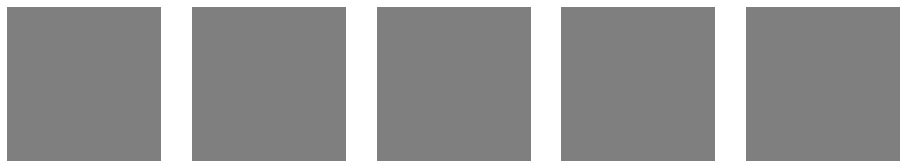

In [15]:
n_images = 5
rand_input = tf.random.normal([n_images,100])

img_generated = generator(rand_input)

plt.figure(figsize=(16,9))
for i in range(n_images):
  plt.subplot(1, n_images, i+1)
  plt.imshow((img_generated[i,...]+1)/2)
  plt.axis("off")
plt.show()

### Discriminador

In [12]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  input = Input(shape=(IMG_WIDTH, IMG_HEIGHT,3))

  x = layers.Conv2D(8, 1, padding="same", kernel_initializer=initializer)(input)
  x = layers.LeakyReLU()(x)
  x = Downsample(16, True)(x)
  x = Downsample(32, True)(x)
  x = Downsample(64, True)(x)
  x = Downsample(128, True)(x)
  x = Downsample(256, True)(x)
  x = Downsample(512, True)(x)
  x = layers.Conv2D(1024, 3, padding="same", kernel_initializer=initializer)(x)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Conv2D(1024, 4, strides=4, padding="same", kernel_initializer=initializer)(x)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(units=1, kernel_initializer=initializer)(x)
  
  return Model(inputs=input, outputs=x)

In [13]:
discriminator = Discriminator()
discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128, 128, 8)       0         
_________________________________________________________________
downsample (Downsample)      (None, 64, 64, 16)        3488      
_________________________________________________________________
downsample_1 (Downsample)    (None, 32, 32, 32)        13888     
_________________________________________________________________
downsample_2 (Downsample)    (None, 16, 16, 64)        55424     
_________________________________________________________________
downsample_3 (Downsample)    (None, 8, 8, 128)         2214

In [18]:
disct = discriminator(img_generated)
print(disct)

tf.Tensor(
[[1.3970897e-16]
 [1.6337333e-16]
 [8.1860679e-17]
 [1.1734865e-16]
 [1.0205991e-16]], shape=(5, 1), dtype=float32)


### Cargar pesos

Los pesos serán cargados si existen en google drive.

In [14]:
generator_path = "./drive/MyDrive/Fake Faces/generator.h5"
discriminator_path = "./drive/MyDrive/Fake Faces/discriminator.h5"

if os.path.isfile(generator_path):
  generator.load_weights(generator_path)

if os.path.isfile(discriminator_path):
  discriminator.load_weights(discriminator_path)

### Funiones de perdida

In [20]:
loss_object = losses.BinaryCrossentropy(from_logits=True)

In [21]:
def generator_loss(disc_generated_output):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  return gan_loss

In [22]:
def discriminator_loss(real_output, generated_output):
  real_loss = loss_object(tf.ones_like(real_output), real_output)
  generated_loss = loss_object(tf.zeros_like(generated_output), generated_output)
  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Funciones de optimización

In [23]:
generator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(2e-4, beta_1=0.5)

## Entrenamiento

In [24]:
@tf.function
def train_step(target):
  seed = tf.random.normal([target.shape[0],SEED_LEGTH])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(seed)
    
    real_output = discriminator(target)
    fake_output = discriminator(gen_output)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
  
  return gen_loss, disc_loss

In [25]:
def fit(seed, train_ds, epochs, start_epoch=0):
  
  display.clear_output(wait=True)
  print(f"Epoch: {start_epoch:03d}/{start_epoch+epochs}")
  generate_and_save_images(generator, 0, seed)

  for epoch in range(start_epoch, start_epoch+epochs):
    start = time.time()

    for target in train_ds:
      gen_loss, disc_loss = train_step(target)

    display.clear_output(wait=True)
    print(f"Epoch: {epoch+1:03d}/{start_epoch+epochs}")
    generate_and_save_images(generator, epoch + 1, seed)

    if (epoch+1)%5 == 0:
      generator.save(generator_path)
      discriminator.save(discriminator_path)

In [26]:
EPOCHS = 300
seed = tf.random.normal([16, SEED_LEGTH])

Epoch: 193/300


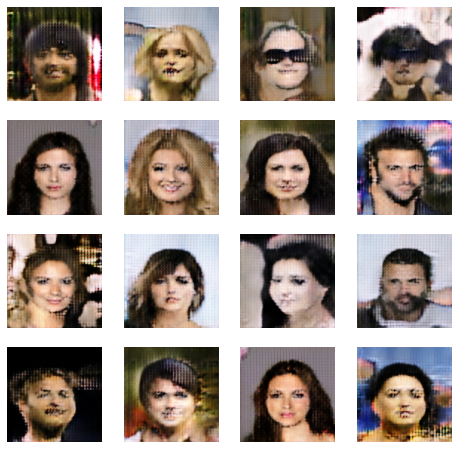

In [ ]:
fit(seed, train_dataset, EPOCHS, 0)

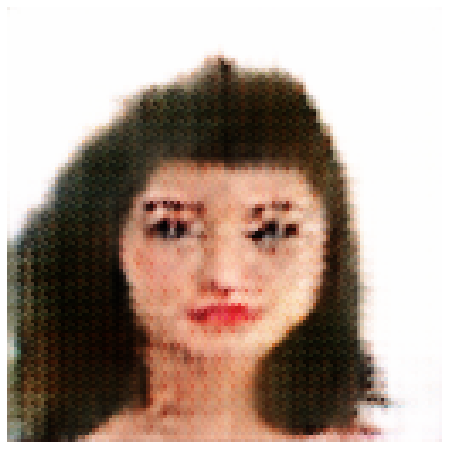

In [48]:
rand_input = tf.random.normal([1,SEED_LEGTH])

img_generated = generator(rand_input)

plt.figure(figsize=(8,8))
plt.imshow(np.clip((img_generated[0,...]+1)/2, 0, 1))
plt.axis("off")
plt.show()

In [33]:
PATH = "/content/drive/My Drive/Fake Faces/Images generated/"
anim_file = PATH+"dcgan.gif"

files = [f"{PATH}{file}" for file in os.listdir(PATH)]
images = [imageio.imread(file) for file in files]
imageio.mimwrite('/content/drive/My Drive/Fake Faces/movie.gif', images, fps=3)